In [1]:
import xarray as xr
import matplotlib.pyplot as plt
from scipy.stats import genextreme as gev
import numpy as np

from unseen import process_utils
from unseen import eva

In [2]:
ds = xr.open_dataset('/g/data/xv83/dbi599/tc-jasper/rx5day_AGCD-CSIRO_r005_1900-2023_A-AUG_daintree-river.nc')

In [3]:
ds = ds.isel({'time': slice(1,125)})

In [4]:
df = ds.to_dataframe()

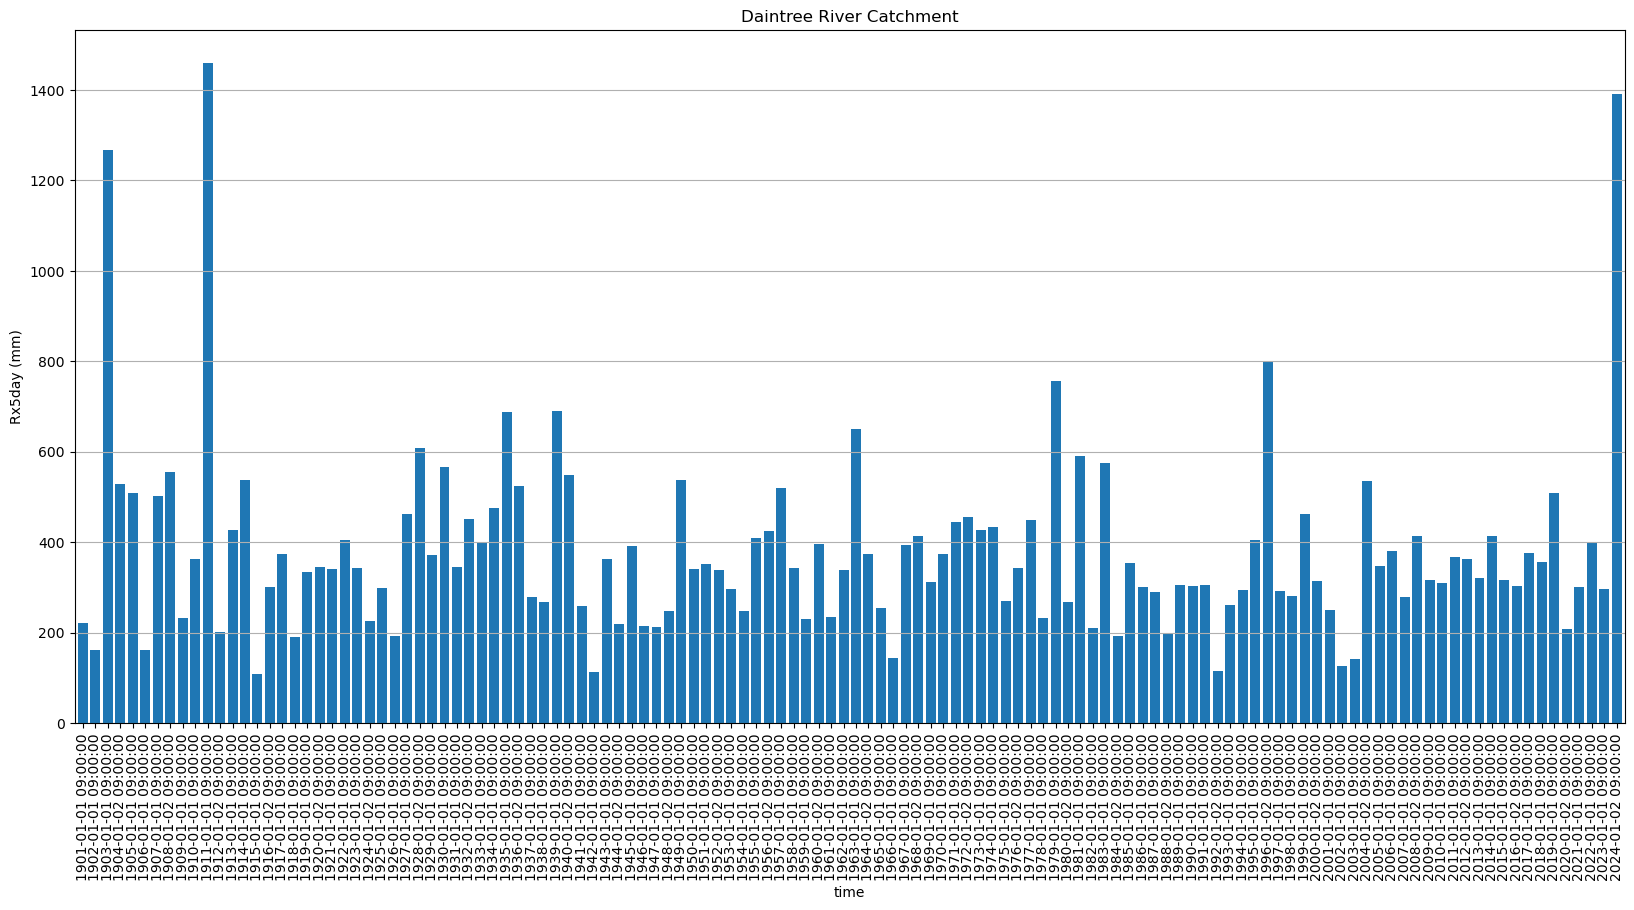

In [5]:
df['pr'].plot.bar(figsize=[20, 9], width=0.8)
plt.ylabel('Rx5day (mm)')
plt.title('Daintree River Catchment')
plt.grid(axis='y')
plt.show()

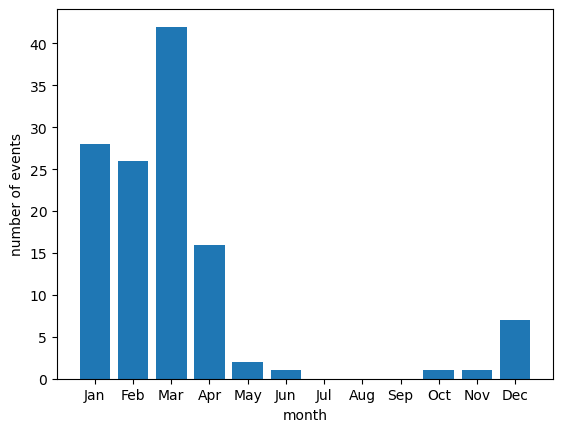

In [6]:
process_utils.plot_event_seasonality(df)

In [7]:
ranked_years = df.sort_values(by='pr', ascending=False)
print(ranked_years.head(n=10))

                              pr  event_time
time                                        
1911-01-01 09:00:00  1459.442017  1911-04-03
2024-01-02 09:00:00  1392.098877  2023-12-18
1903-01-01 09:00:00  1267.950684  1903-04-23
1996-01-02 09:00:00   799.335449  1996-03-08
1979-01-01 09:00:00   756.700500  1979-01-05
1939-01-01 09:00:00   689.864258  1939-03-25
1935-01-01 09:00:00   688.977478  1935-03-04
1963-01-01 09:00:00   650.727356  1963-04-10
1928-01-02 09:00:00   607.283936  1928-02-29
1981-01-01 09:00:00   589.572449  1981-01-13


According to the [BoM Queensland Flood history](http://www.bom.gov.au/qld/flood/fld_history/floodsum_1910.shtml):
"1st April: Heavy rain in north Queensland. Record floods at Palmerville and Walsh River; big loss of stock. On the 1st, 2nd, and 3rd the Barron River was in flood at Kuranda; flood estimated to be the highest on record."

In [8]:
rx5day_2023 = ranked_years.iloc[1]['pr']

In [9]:
rx5day_2023

1392.0989

In [10]:
gev23_shape, gev23_loc, gev23_scale = eva.fit_gev(ds['pr'].values, user_estimates=[-0.11, 293.6, 122.19])
gev22_shape, gev22_loc, gev22_scale = eva.fit_gev(ds['pr'].values[:-1], user_estimates=[-0.07, 293, 122])

In [52]:
print(gev23_shape, gev23_loc, gev23_scale)
print(gev22_shape, gev22_loc, gev22_scale)

-0.11454837453226169 293.6193598218641 122.18103434306002
-0.0778988051057505 293.42998816246364 119.50335401594131


In [53]:
gev.fit(ds['pr'].values, loc=293, scale=122)

(-0.11456176709753531, 293.62019772300346, 122.19504208387724)

484 year return period
95% CI: 3-27127 years


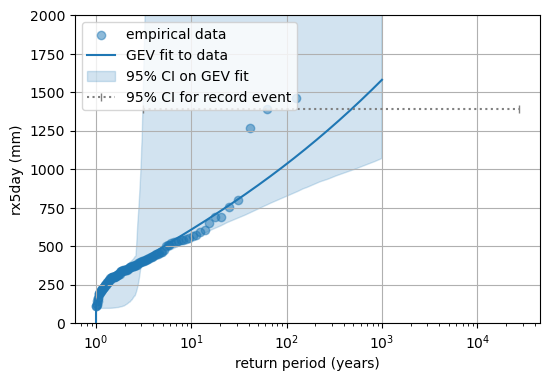

In [13]:
fig = plt.figure(figsize=[6, 4])
ax = fig.add_subplot()
eva.plot_gev_return_curve(
    ax,
    ds['pr'].values,
    rx5day_2023,
#    n_bootstraps=100,
    direction="exceedance",
    ylabel='rx5day (mm)',
    ylim=(0, 2000),
    max_return_period=3,
    user_estimates=[gev23_shape, gev23_loc, gev23_scale]
)
plt.show()

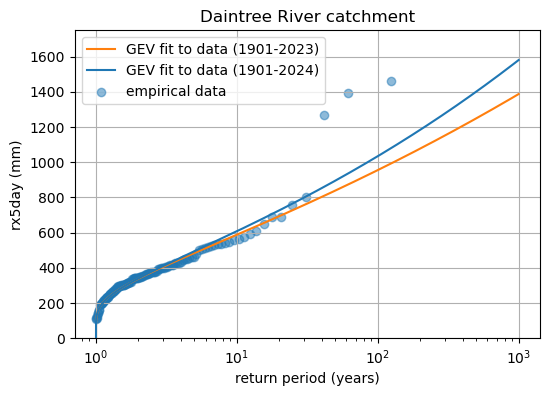

In [23]:
fig = plt.figure(figsize=[6, 4])
ax = fig.add_subplot()

curve_return_periods = np.logspace(0, 3, num=10000)
curve_probabilities = 1.0 / curve_return_periods
curve_values22 = gev.isf(curve_probabilities, gev22_shape, gev22_loc, gev22_scale)
ax.plot(
    curve_return_periods,
    curve_values22,
    color="tab:orange",
    label="GEV fit to data (1901-2023)",
)
curve_values23 = gev.isf(curve_probabilities, gev23_shape, gev23_loc, gev23_scale)
ax.plot(
    curve_return_periods,
    curve_values23,
    color="tab:blue",
    label="GEV fit to data (1901-2024)",
)

empirical_return_values = np.sort(ds['pr'].values, axis=None)[::-1]
empirical_return_periods = len(ds['pr'].values) / np.arange(1.0, len(ds['pr'].values) + 1.0)
ax.scatter(
    empirical_return_periods,
    empirical_return_values,
    color="tab:blue",
    alpha=0.5,
    label="empirical data",
)

ax.set_xscale("log")
ax.set_xlabel("return period (years)")
ax.set_ylabel("rx5day (mm)")
ax.set_ylim(0, 1750)
ax.grid()
ax.legend()
ax.set_title('Daintree River catchment')

plt.show()

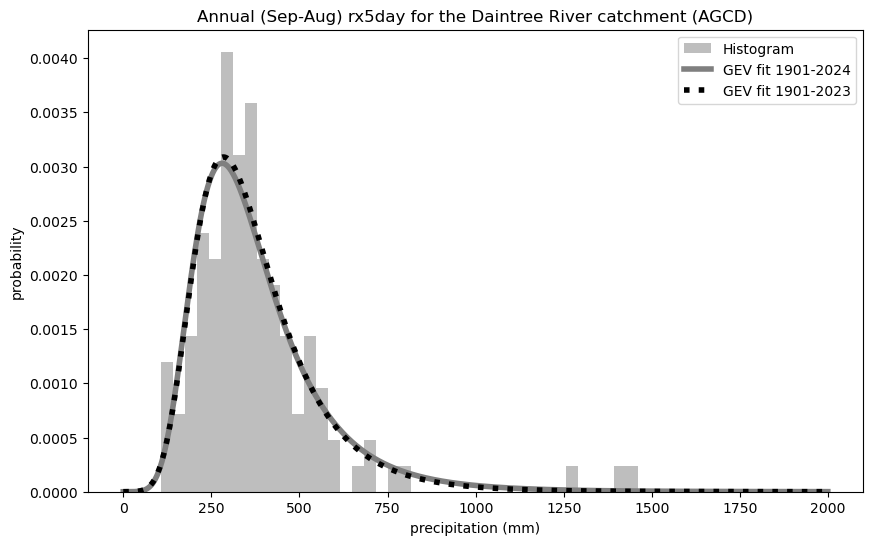

# Full timeseries (1901-2024)
483.731 year return period
99.79% percentile

# No record timeseries (1901-2023)
1026.382 year return period
99.90% percentile


In [21]:
fig, ax = plt.subplots(figsize=[10, 6])
gev_xvals = np.arange(0, 2000)
ds['pr'].plot.hist(bins=40, density=True, color='tab:gray', alpha=0.5, label='Histogram')
gev23_pdf = gev.pdf(gev_xvals, gev23_shape, gev23_loc, gev23_scale)
plt.plot(gev_xvals, gev23_pdf, color='tab:gray', linewidth=4.0, label='GEV fit 1901-2024')
gev22_pdf = gev.pdf(gev_xvals, gev22_shape, gev22_loc, gev22_scale)
plt.plot(gev_xvals, gev22_pdf, color='black', linewidth=4.0, linestyle=':', label='GEV fit 1901-2023')
plt.xlabel('precipitation (mm)')
plt.ylabel('probability')
plt.title(f'Annual (Sep-Aug) rx5day for the Daintree River catchment (AGCD)')
#plt.xlim(0, 500)
plt.legend()
#plt.savefig(
#    '/g/data/xv83/dbi599/tc-jasper/figures/rx5day_histogram_AGCD_daintree-river.png',
#    bbox_inches='tight',
#    facecolor='white',
#)
plt.show()
    
event23_probability = gev.sf(rx5day_2023, gev23_shape, loc=gev23_loc, scale=gev23_scale)
event23_return_period = 1. / event23_probability
event23_percentile = (1 - event23_probability) * 100
print('# Full timeseries (1901-2024)')
print(f'{event23_return_period:.3f} year return period')
print(f'{event23_percentile:.2f}% percentile\n')
    
event22_probability = gev.sf(rx5day_2023, gev22_shape, loc=gev22_loc, scale=gev22_scale)
event22_return_period = 1. / event22_probability
event22_percentile = (1 - event22_probability) * 100
print('# No record timeseries (1901-2023)')
print(f'{event22_return_period:.3f} year return period')
print(f'{event22_percentile:.2f}% percentile')